# Transfermarkt 데이터 분석 프로젝트
* Transfermarkt에 등록된 market value top 500 선수의 데이터를 분석
* 분석 목적: 
    1. 선수 가치에 영향을 주는 요인 분석하기
    2. 선수 가치를 예측하는 모델 만들기
* 데이터는 웹 크롤러를 활용하여 수집

### Description
* name: 이름
* age: 나이 (만 나이)
* height: 신장
* country: 국적 (다중 국적일 경우, 모두 표기)
* position: 주 포지션
* foot: 주발
* team: 현재 소속 팀
* joined: 현재 소속 팀 입단 일자
* contract expires: 계약 만료일
* goals: 19-20시즌 총 득점 수
* assists: 19-20시즌 총 도움 수
* appearances: 19-20시즌 총 출장 수
* market value: Transfermarkt 기준 선수 가치

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 격자와 보다 나은 데이터 표현을 위해 스타일 적용
plt.style.use('seaborn-whitegrid')
# 노트북 안에 그래프 그리기
%matplotlib inline
# 경고 무시
warnings.filterwarnings('ignore')
# pandas float 표시 형식 지정
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv('source/TransferMarket.csv', index_col=0)

In [3]:
df.shape

(500, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 13 columns):
name                500 non-null object
age                 500 non-null int64
height              500 non-null object
country             500 non-null object
position            500 non-null object
foot                500 non-null object
team                500 non-null object
joined              500 non-null object
contract expires    500 non-null object
goals               500 non-null object
assists             500 non-null object
appearances         500 non-null object
market value        500 non-null object
dtypes: int64(1), object(12)
memory usage: 54.7+ KB


In [5]:
df.head()

,name,age,height,country,position,foot,team,joined,contract expires,goals,assists,appearances,market value
0,Kylian Mbappé,21,"1,78 m",France,Forward - Centre-Forward,right,Paris Saint-Germain,"Jul 1, 2018",30.06.2022,30,17,33,€200.00m
1,Raheem Sterling,25,"1,70 m",England,Forward - Left Winger,right,Manchester City,"Jul 14, 2015",30.06.2023,20,7,39,€160.00m
2,Neymar,28,"1,75 m",Brazil,Forward - Left Winger,right,Paris Saint-Germain,"Aug 3, 2017",30.06.2022,18,10,22,€160.00m
3,Sadio Mané,27,"1,74 m",Senegal,Forward - Left Winger,right,Liverpool FC,"Jul 1, 2016",30.06.2023,18,12,38,€150.00m
4,Mohamed Salah,27,"1,75 m",Egypt,Forward - Right Winger,left,Liverpool FC,"Jul 1, 2017",30.06.2023,20,9,40,€150.00m


### 데이터 살펴보기
* 음바페가 2억 유로(한화 약 2,672억)로 가장 높은 시장 가치를 자랑한다.
    * 데이터로 보면 21세의 어린 나이임에도, PSG라는 빅클럽에서 33경기나 소화하고, 33득점 17도움이라는 엄청난 기록을 세우고 있기 때문으로 보인다.

* 상위 5명은 모두 공격수이다.
    * 1위 음바페를 제외하면, 모두 윙포워드 포지션이다.
    * 축구는 골을 넣어야 이기기 때문에 공격수의 몸값이 높은 것으로 보인다.

더 살펴보기 전에, 일단 전처리부터 해보자.

- - - -
### 데이터 전처리 - to numeric
* 본격적으로 데이터를 살펴보기 전에, 몇가지 처리를 해야할 것 같다.
* object to numeric 으로 변환해야하는 컬럼이 많다.
    1. height는 숫자 사이에 포함된 문자를 제거하여 보기 편하게 하는 것이 좋겠다.
    2. goals, assists, appearances는 보이기엔 숫자이지만, 문자 형식으로 되어있다.
    3. market value는 유로(€)를 원화(\)로 바꾸고, 숫자로 변경하는 것이 좋겠다.
        * 20.04.05 기준, 1 유로 = 1,336.37 원 으로 계산

In [6]:
# height 컬럼 내 문자 제거, int로 변환
import re
p = re.compile('\D')
for row in range(0, 500):
    df.loc[row, 'height'] = int(p.sub('', df.loc[row, 'height']))

In [7]:
# market value 컬럼 내 문자 제거, int type으로 변환, 유로 to 원화 계산
p = re.compile('(€|m|[.]00)') # 유로 화폐 문자(€)와 백만 단위 문자(m) 컴파일
for row in range(0, 500):
    df.loc[row, 'market value'] = float(p.sub('', df.loc[row, 'market value'])) * 1000000.1 * 1336.37    # 백만(m) * 유로 환율

In [8]:
# goals, assists, appearances 컬럼의 type을 int로 변환, '-'문자는 0으로 채움
# height, market value 컬럼도 숫자로 변환
# age, height, goals, assists, appearances 컬럼은 flaot에서 int로 변경 (age는 int62 to int32로 변경)
for col in ['height', 'goals', 'assists', 'appearances', 'market value']:
    df[col] = df[col].apply(pd.to_numeric, errors = 'coerce').fillna(0)
for col in ['age', 'height', 'goals', 'assists', 'appearances']:
    df[col] = df[col].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 13 columns):
name                500 non-null object
age                 500 non-null int32
height              500 non-null int32
country             500 non-null object
position            500 non-null object
foot                500 non-null object
team                500 non-null object
joined              500 non-null object
contract expires    500 non-null object
goals               500 non-null int32
assists             500 non-null int32
appearances         500 non-null int32
market value        500 non-null float64
dtypes: float64(1), int32(5), object(7)
memory usage: 64.9+ KB


In [9]:
df.head()

,name,age,height,country,position,foot,team,joined,contract expires,goals,assists,appearances,market value
0,Kylian Mbappé,21,178,France,Forward - Centre-Forward,right,Paris Saint-Germain,"Jul 1, 2018",30.06.2022,30,17,33,267274026727.40
1,Raheem Sterling,25,170,England,Forward - Left Winger,right,Manchester City,"Jul 14, 2015",30.06.2023,20,7,39,213819221381.92
2,Neymar,28,175,Brazil,Forward - Left Winger,right,Paris Saint-Germain,"Aug 3, 2017",30.06.2022,18,10,22,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward - Left Winger,right,Liverpool FC,"Jul 1, 2016",30.06.2023,18,12,38,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward - Right Winger,left,Liverpool FC,"Jul 1, 2017",30.06.2023,20,9,40,200455520045.55


* height, goals, assists, appearances, market value의 형식을 모두 변경하였다.
    * market value는 계속 object로 뜨는데 왜 그런지 확인해봐야함!

### 데이터 전처리 - to datetime
* 다음으로는, joined, contract expires 컬럼을 살펴보자.
    * 두 컬럼은 모두 날짜를 가르키고있지만, 서로 형식이 다르다.
* 두 컬럼을 pandas datetime 형식으로 변환하여 통일하자.


In [10]:
for col in ['joined', 'contract expires']:
    df[col] = pd.to_datetime(df[col])

In [11]:
df.head()

,name,age,height,country,position,foot,team,joined,contract expires,goals,assists,appearances,market value
0,Kylian Mbappé,21,178,France,Forward - Centre-Forward,right,Paris Saint-Germain,2018-07-01,2022-06-30,30,17,33,267274026727.40
1,Raheem Sterling,25,170,England,Forward - Left Winger,right,Manchester City,2015-07-14,2023-06-30,20,7,39,213819221381.92
2,Neymar,28,175,Brazil,Forward - Left Winger,right,Paris Saint-Germain,2017-08-03,2022-06-30,18,10,22,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward - Left Winger,right,Liverpool FC,2016-07-01,2023-06-30,18,12,38,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward - Right Winger,left,Liverpool FC,2017-07-01,2023-06-30,20,9,40,200455520045.55


### 데이터 전처리 - position
* 다음으로, position컬럼을 살펴보자.
* 포지션, 세부 포지션 두 컬럼으로 나누면 더 좋을 것 같은데, 데이터가 어떤 범주로 구성되어있는지 살펴보자.

In [12]:
df.position.value_counts()

Midfielder - Central Midfield      82
Defender - Centre-Back             82
Forward - Centre-Forward           71
Forward - Right Winger             47
Forward - Left Winger              46
Midfielder - Defensive Midfield    42
Midfielder - Attacking Midfield    40
Defender - Right-Back              26
Defender - Left-Back               26
Goalkeeper                         18
Forward - Second Striker            9
Midfielder - Left Midfield          8
Midfielder - Right Midfield         3
Name: position, dtype: int64

* [Defender, Midfielder, Defender] - [세부포지션] 의 형식으로 구성되어있다.
* Goalkeeper의 경우, 세부 포지션이 없다.
* position, position-detail 이렇게 두 컬럼으로 나누면 좋을 것 같다.

In [13]:
for row in range(0, 500):
    if df.loc[row, 'position'] == 'Goalkeeper':    # Goalkeeper일 경우, position-detail컬럼에도 Goalkeeper
        df.loc[row, 'position-detail'] = 'Goalkeeper'
    else:
        df.loc[row, 'position-detail'] = re.findall('\w+\W{1}\w+', df.loc[row, 'position'])    # position-detail컬럼에는 상세 포지션 추가
        df.loc[row, 'position'] = re.findall('[a-zA-Z]+', df.loc[row, 'position'])[0]    # position컬럼에는 메인 포지션만 유지

In [14]:
# 컬럼 순서 변경
df = df[['name', 'age', 'height', 'country', 'position', 'position-detail', 'foot', 'team', 'joined', 'contract expires', 'goals', 'assists', 'appearances', 'market value']]
df.head()

,name,age,height,country,position,position-detail,foot,team,joined,contract expires,goals,assists,appearances,market value
0,Kylian Mbappé,21,178,France,Forward,Centre-Forward,right,Paris Saint-Germain,2018-07-01,2022-06-30,30,17,33,267274026727.40
1,Raheem Sterling,25,170,England,Forward,Left Winger,right,Manchester City,2015-07-14,2023-06-30,20,7,39,213819221381.92
2,Neymar,28,175,Brazil,Forward,Left Winger,right,Paris Saint-Germain,2017-08-03,2022-06-30,18,10,22,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward,Left Winger,right,Liverpool FC,2016-07-01,2023-06-30,18,12,38,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward,Right Winger,left,Liverpool FC,2017-07-01,2023-06-30,20,9,40,200455520045.55


In [15]:
# 제대로 나뉘어졌는지 확인
print('position 컬럼:\n{}\n\nposition-detail 컬럼:\n{}'.format(df['position'].value_counts(), df['position-detail'].value_counts()))

position 컬럼:
Midfielder    175
Forward       173
Defender      134
Goalkeeper     18
Name: position, dtype: int64

position-detail 컬럼:
Centre-Back           82
Central Midfield      82
Centre-Forward        71
Right Winger          47
Left Winger           46
Defensive Midfield    42
Attacking Midfield    40
Right-Back            26
Left-Back             26
Goalkeeper            18
Second Striker         9
Left Midfield          8
Right Midfield         3
Name: position-detail, dtype: int64


* position 컬럼을 position, position-detail 두 컬럼으로 나누고, 컬럼의 순서도 제대로 변경되었다.

### 데이터 전처리 - team과 league
* 선수가 어떤 팀에 속해있는지도 굉장히 중요하지만, 그 팀이 어떤 리그에 속해있는지도 중요할 것이다.
* 리그 컬럼을 추가하고, 선수가 속한 팀에 해당하는 리그를 추가해보자.

In [16]:
# 모든 팀의 unique value 찾기
df.team.unique()

array(['Paris Saint-Germain', 'Manchester City', 'Liverpool FC',
       'Tottenham Hotspur', 'FC Barcelona', 'Borussia Dortmund',
       'Chelsea FC', 'Manchester United', 'Atlético Madrid',
       'Real Madrid', 'Bayer 04 Leverkusen', 'Juventus FC',
       'Bayern Munich', 'Inter Milan', 'SS Lazio', 'RB Leipzig',
       'SSC Napoli', 'Arsenal FC', 'Everton FC', 'Real Sociedad',
       'ACF Fiorentina', 'Leicester City', 'Olympique Lyon',
       'West Ham United', 'AC Milan', 'Ajax Amsterdam', 'Crystal Palace',
       'Valencia CF', 'AS Roma', 'Athletic Bilbao',
       'Wolverhampton Wanderers', 'AS Monaco', 'Borussia Mönchengladbach',
       'Atalanta BC', 'Stade Rennais FC', 'Sevilla FC', 'LOSC Lille',
       'FC Porto', 'Olympique Marseille', 'Torino FC',
       'Eintracht Frankfurt', 'Zenit St. Petersburg', 'SL Benfica',
       'Aston Villa', 'TSG 1899 Hoffenheim', 'Parma Calcio 1913',
       'Brescia Calcio', 'Grêmio Foot-Ball Porto Alegrense',
       'SV Werder Bremen', 'AFC Bour

In [17]:
# 'Premier League'
epl = ['Manchester City', 'Liverpool FC', 'Tottenham Hotspur', 'Chelsea FC', 'Manchester United', 'Arsenal FC', 'Everton FC', 'Leicester City', 'West Ham United', 'Crystal Palace', 'Wolverhampton Wanderers', 'Aston Villa', 'Watford FC',  'Norwich City',  'Fulham FC', 'Newcastle United', 'AFC Bournemouth', 'Burnley FC', 'Sheffield United', 'Brighton & Hove Albion', 'Southampton FC']

# 'LaLiga'
laliga = ['FC Barcelona', 'Atlético Madrid', 'Real Madrid', 'Real Sociedad','Valencia CF', 'Athletic Bilbao', 'Villarreal CF', 'Getafe CF', 'Real Betis Balompié', 'RCD Espanyol Barcelona']

# 'Ligue 1'
ligue1 = ['Paris Saint-Germain', 'Olympique Lyon', 'AS Monaco','Sevilla FC', 'Stade Rennais FC', 'LOSC Lille', 'Olympique Marseille', 'AS Saint-Étienne', 'OGC Nice']

# Bundesliga
bundesliga = ['Borussia Dortmund', 'Bayer 04 Leverkusen', 'Bayern Munich', 'RB Leipzig', 'Borussia Mönchengladbach', 'Eintracht Frankfurt', 'FC Schalke 04', 'TSG 1899 Hoffenheim', 'SV Werder Bremen', 'Hertha BSC', 'VfL Wolfsburg', '1.FSV Mainz 05', 'SC Freiburg']

# Serie A
serieA = ['Juventus FC', 'Inter Milan', 'SS Lazio', 'SSC Napoli', 'ACF Fiorentina', 'AC Milan', 'AS Roma', 'Atalanta BC', 'Torino FC', 'Parma Calcio 1913', 'Brescia Calcio', 'Cagliari Calcio', 'Hellas Verona', 'Bologna FC 1909', 'Udinese Calcio', 'US Sassuolo']

In [18]:
for row in range(0, 500):
    if df.loc[row, 'team'] in epl:
        df.loc[row,'league'] = 'Premier League'
    elif df.loc[row, 'team'] in laliga:
        df.loc[row,'league'] = 'LaLiga'
    elif df.loc[row, 'team'] in ligue1:
        df.loc[row,'league'] = 'Ligue 1'
    elif df.loc[row, 'team'] in bundesliga:
        df.loc[row,'league'] = 'Bundesliga'
    elif df.loc[row, 'team'] in serieA:
        df.loc[row,'league'] = 'Serie A'
    else:
        df.loc[row,'league'] = 'Other league'

In [19]:
# 컬럼 순서 변경
df = df[['name', 'age', 'height', 'country', 'position', 'position-detail', 'foot', 'league', 'team', 'joined', 'contract expires', 'goals', 'assists', 'appearances', 'market value']]
df.head()

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,market value
0,Kylian Mbappé,21,178,France,Forward,Centre-Forward,right,Ligue 1,Paris Saint-Germain,2018-07-01,2022-06-30,30,17,33,267274026727.40
1,Raheem Sterling,25,170,England,Forward,Left Winger,right,Premier League,Manchester City,2015-07-14,2023-06-30,20,7,39,213819221381.92
2,Neymar,28,175,Brazil,Forward,Left Winger,right,Ligue 1,Paris Saint-Germain,2017-08-03,2022-06-30,18,10,22,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward,Left Winger,right,Premier League,Liverpool FC,2016-07-01,2023-06-30,18,12,38,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward,Right Winger,left,Premier League,Liverpool FC,2017-07-01,2023-06-30,20,9,40,200455520045.55


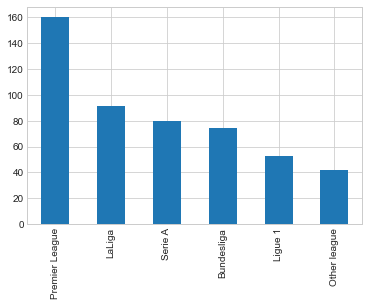

In [20]:
df.league.value_counts().plot('bar')
plt.show()

* 유럽 5대 리그에 대해 각 리그명을 추가하였고, 그 외 리그는 Other league로 표시하였다.

### 데이터 전처리 - country

In [21]:
df.head(10)

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,market value
0,Kylian Mbappé,21,178,France,Forward,Centre-Forward,right,Ligue 1,Paris Saint-Germain,2018-07-01,2022-06-30,30,17,33,267274026727.40
1,Raheem Sterling,25,170,England,Forward,Left Winger,right,Premier League,Manchester City,2015-07-14,2023-06-30,20,7,39,213819221381.92
2,Neymar,28,175,Brazil,Forward,Left Winger,right,Ligue 1,Paris Saint-Germain,2017-08-03,2022-06-30,18,10,22,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward,Left Winger,right,Premier League,Liverpool FC,2016-07-01,2023-06-30,18,12,38,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward,Right Winger,left,Premier League,Liverpool FC,2017-07-01,2023-06-30,20,9,40,200455520045.55
5,Harry Kane,26,188,England,Forward,Centre-Forward,right,Premier League,Tottenham Hotspur,2011-01-01,2024-06-30,17,2,25,200455520045.55
6,Kevin De Bruyne,28,181,Belgium,Midfielder,Attacking Midfield,right,Premier League,Manchester City,2015-08-30,2023-06-30,9,20,35,200455520045.55
7,Lionel Messi,32,170,Argentina\n Spain,Forward,Right Winger,left,LaLiga,FC Barcelona,2005-07-01,2021-06-30,24,16,31,187091818709.18
8,Jadon Sancho,20,180,England,Forward,Right Winger,right,Bundesliga,Borussia Dortmund,2017-08-31,2022-06-30,17,19,35,173728117372.81
9,Antoine Griezmann,29,176,France,Forward,Left Winger,left,LaLiga,FC Barcelona,2019-07-14,2024-06-30,14,4,37,160364416036.44


* 메시([7] 레코드)의 국적을 보면, 단일 국적이 아니다.
* 보다 쉬운 분석을 위해, 첫 번째 국적만 남겨보자.

In [22]:
for row in range(0, 500):
    df.loc[row, 'country'] = re.findall('[\w]+', df.loc[row, 'country'])[0]
df.head(10)

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,market value
0,Kylian Mbappé,21,178,France,Forward,Centre-Forward,right,Ligue 1,Paris Saint-Germain,2018-07-01,2022-06-30,30,17,33,267274026727.40
1,Raheem Sterling,25,170,England,Forward,Left Winger,right,Premier League,Manchester City,2015-07-14,2023-06-30,20,7,39,213819221381.92
2,Neymar,28,175,Brazil,Forward,Left Winger,right,Ligue 1,Paris Saint-Germain,2017-08-03,2022-06-30,18,10,22,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward,Left Winger,right,Premier League,Liverpool FC,2016-07-01,2023-06-30,18,12,38,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward,Right Winger,left,Premier League,Liverpool FC,2017-07-01,2023-06-30,20,9,40,200455520045.55
5,Harry Kane,26,188,England,Forward,Centre-Forward,right,Premier League,Tottenham Hotspur,2011-01-01,2024-06-30,17,2,25,200455520045.55
6,Kevin De Bruyne,28,181,Belgium,Midfielder,Attacking Midfield,right,Premier League,Manchester City,2015-08-30,2023-06-30,9,20,35,200455520045.55
7,Lionel Messi,32,170,Argentina,Forward,Right Winger,left,LaLiga,FC Barcelona,2005-07-01,2021-06-30,24,16,31,187091818709.18
8,Jadon Sancho,20,180,England,Forward,Right Winger,right,Bundesliga,Borussia Dortmund,2017-08-31,2022-06-30,17,19,35,173728117372.81
9,Antoine Griezmann,29,176,France,Forward,Left Winger,left,LaLiga,FC Barcelona,2019-07-14,2024-06-30,14,4,37,160364416036.44


* 메시의 국적이 이제 아르헨티나로만 표시된다.

### 데이터 전처리 - goalkeeper's goals, assists?
* 이 데이터에는 필드플레이어 뿐만 아니라 골키퍼까지 포함되어있다.
* 골키퍼들의 성적은 득점과 도움이 아닌, 실점, 클린시트 등이 될 것이다.
* 먼저, 골키퍼들의 데이터를 살펴보자.

In [23]:
df[df.position == 'Goalkeeper']

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,market value
16,Jan Oblak,27,188,Slovenia,Goalkeeper,Goalkeeper,right,LaLiga,Atlético Madrid,2014-07-16,2023-06-30,30,16,37,133637013363.70
25,Alisson,27,191,Brazil,Goalkeeper,Goalkeeper,right,Premier League,Liverpool FC,2018-07-19,2024-06-30,17,14,28,120273312027.33
26,Marc-André ter Stegen,27,187,Germany,Goalkeeper,Goalkeeper,right,LaLiga,FC Barcelona,2014-07-01,2022-06-30,0,0,34,120273312027.33
51,Ederson,26,188,Brazil,Goalkeeper,Goalkeeper,left,Premier League,Manchester City,2017-07-01,2025-06-30,27,13,31,93545909354.59
83,Thibaut Courtois,27,199,Belgium,Goalkeeper,Goalkeeper,left,LaLiga,Real Madrid,2018-08-09,2024-06-30,26,15,32,80182208018.22
90,Gianluigi Donnarumma,21,196,Italy,Goalkeeper,Goalkeeper,right,Serie A,AC Milan,2015-07-01,2021-06-30,33,10,26,73500357350.03
128,David de Gea,29,189,Spain,Goalkeeper,Goalkeeper,right,Premier League,Manchester United,2011-07-01,2023-06-30,33,10,32,66818506681.85
139,André Onana,24,190,Cameroon,Goalkeeper,Goalkeeper,right,Other league,Ajax Amsterdam,2015-01-14,2022-06-30,37,15,39,60136656013.66
169,Kepa,25,186,Spain,Goalkeeper,Goalkeeper,right,Premier League,Chelsea FC,2018-08-08,2025-06-30,43,8,33,53454805345.48
187,Wojciech Szczesny,29,196,Poland,Goalkeeper,Goalkeeper,right,Serie A,Juventus FC,2017-07-19,2024-06-30,25,10,26,53454805345.48


* 골키퍼들의 스탯을 살펴보면, 득점과 도움의 수가 심상치 않다.
    * 사이트에 가서 직접 확인해보니, 골키퍼들은 득점과 도움을 기록해놓은 창이 없었다.
    * 잘못된 수치를 수집한 것이 원인이었다.
* 이를 해경하기 위해 골키퍼와 득점, 도움 수는 0으로 변경해야한다.
* 그 후 골키퍼에게 맞는 스탯인 실점 수, 클린시트 수를 수집해서 컬럼을 추가해야겠다.

In [24]:
# 골키퍼의 득점, 도움 수 0으로 바꾸기
for row in df[df.position == 'Goalkeeper'].index:
    df.loc[row, 'goals'] = 0
    df.loc[row, 'assists'] = 0
df[df.position == 'Goalkeeper']

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,market value
16,Jan Oblak,27,188,Slovenia,Goalkeeper,Goalkeeper,right,LaLiga,Atlético Madrid,2014-07-16,2023-06-30,0,0,37,133637013363.70
25,Alisson,27,191,Brazil,Goalkeeper,Goalkeeper,right,Premier League,Liverpool FC,2018-07-19,2024-06-30,0,0,28,120273312027.33
26,Marc-André ter Stegen,27,187,Germany,Goalkeeper,Goalkeeper,right,LaLiga,FC Barcelona,2014-07-01,2022-06-30,0,0,34,120273312027.33
51,Ederson,26,188,Brazil,Goalkeeper,Goalkeeper,left,Premier League,Manchester City,2017-07-01,2025-06-30,0,0,31,93545909354.59
83,Thibaut Courtois,27,199,Belgium,Goalkeeper,Goalkeeper,left,LaLiga,Real Madrid,2018-08-09,2024-06-30,0,0,32,80182208018.22
90,Gianluigi Donnarumma,21,196,Italy,Goalkeeper,Goalkeeper,right,Serie A,AC Milan,2015-07-01,2021-06-30,0,0,26,73500357350.03
128,David de Gea,29,189,Spain,Goalkeeper,Goalkeeper,right,Premier League,Manchester United,2011-07-01,2023-06-30,0,0,32,66818506681.85
139,André Onana,24,190,Cameroon,Goalkeeper,Goalkeeper,right,Other league,Ajax Amsterdam,2015-01-14,2022-06-30,0,0,39,60136656013.66
169,Kepa,25,186,Spain,Goalkeeper,Goalkeeper,right,Premier League,Chelsea FC,2018-08-08,2025-06-30,0,0,33,53454805345.48
187,Wojciech Szczesny,29,196,Poland,Goalkeeper,Goalkeeper,right,Serie A,Juventus FC,2017-07-19,2024-06-30,0,0,26,53454805345.48


In [25]:
# 실점 수, 클린시트 수 직접 입력해주기

# Jan Oblak
df.loc[16, 'goals conceded'] = 30
df.loc[16, 'clean sheets'] = 16
# Alisson
df.loc[25, 'goals conceded'] = 17
df.loc[25, 'clean sheets'] = 14
# Marc-André ter Stegen
df.loc[26, 'goals conceded'] = 34
df.loc[26, 'clean sheets'] = 11
# Ederson
df.loc[51, 'goals conceded'] = 27
df.loc[51, 'clean sheets'] = 13
# Thibaut Courtois
df.loc[83, 'goals conceded'] = 26
df.loc[83, 'clean sheets'] = 15
# Gianluigi Donnarumma
df.loc[128, 'goals conceded'] = 33
df.loc[128, 'clean sheets'] = 10
# David de Gea
df.loc[90, 'goals conceded'] = 33
df.loc[90, 'clean sheets'] = 10
# André Onana
df.loc[139, 'goals conceded'] = 37
df.loc[139, 'clean sheets'] = 15
# Kepa
df.loc[169, 'goals conceded'] = 43
df.loc[169, 'clean sheets'] = 8
# Wojciech Szczesny
df.loc[187, 'goals conceded'] = 25
df.loc[187, 'clean sheets'] = 10
# Alex Meret
df.loc[216, 'goals conceded'] = 27
df.loc[216, 'clean sheets'] = 6
# Jordan Pickford
df.loc[230, 'goals conceded'] = 51
df.loc[230, 'clean sheets'] = 8
# Bernd Leno
df.loc[237, 'goals conceded'] = 38
df.loc[237, 'clean sheets'] = 8
# Thomas Strakosha
df.loc[362, 'goals conceded'] = 32
df.loc[362, 'clean sheets'] = 9
# Pau López
df.loc[387, 'goals conceded'] = 43
df.loc[387, 'clean sheets'] = 9
# Mike Maignan
df.loc[424, 'goals conceded'] = 45
df.loc[424, 'clean sheets'] = 13
# Anthony Lopes
df.loc[436, 'goals conceded'] = 41
df.loc[436, 'clean sheets'] = 12
# Unai Simón
df.loc[476, 'goals conceded'] = 22
df.loc[476, 'clean sheets'] = 12

In [26]:
# 컬럼 순서 조정
df = df[['name', 'age', 'height', 'country', 'position', 'position-detail', 'foot', 'league', 'team', 'joined', 'contract expires', 'goals', 'assists', 'appearances', 'goals conceded', 'clean sheets', 'market value']]
df[df.position == 'Goalkeeper']

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,goals conceded,clean sheets,market value
16,Jan Oblak,27,188,Slovenia,Goalkeeper,Goalkeeper,right,LaLiga,Atlético Madrid,2014-07-16,2023-06-30,0,0,37,30.00,16.00,133637013363.70
25,Alisson,27,191,Brazil,Goalkeeper,Goalkeeper,right,Premier League,Liverpool FC,2018-07-19,2024-06-30,0,0,28,17.00,14.00,120273312027.33
26,Marc-André ter Stegen,27,187,Germany,Goalkeeper,Goalkeeper,right,LaLiga,FC Barcelona,2014-07-01,2022-06-30,0,0,34,34.00,11.00,120273312027.33
51,Ederson,26,188,Brazil,Goalkeeper,Goalkeeper,left,Premier League,Manchester City,2017-07-01,2025-06-30,0,0,31,27.00,13.00,93545909354.59
83,Thibaut Courtois,27,199,Belgium,Goalkeeper,Goalkeeper,left,LaLiga,Real Madrid,2018-08-09,2024-06-30,0,0,32,26.00,15.00,80182208018.22
90,Gianluigi Donnarumma,21,196,Italy,Goalkeeper,Goalkeeper,right,Serie A,AC Milan,2015-07-01,2021-06-30,0,0,26,33.00,10.00,73500357350.03
128,David de Gea,29,189,Spain,Goalkeeper,Goalkeeper,right,Premier League,Manchester United,2011-07-01,2023-06-30,0,0,32,33.00,10.00,66818506681.85
139,André Onana,24,190,Cameroon,Goalkeeper,Goalkeeper,right,Other league,Ajax Amsterdam,2015-01-14,2022-06-30,0,0,39,37.00,15.00,60136656013.66
169,Kepa,25,186,Spain,Goalkeeper,Goalkeeper,right,Premier League,Chelsea FC,2018-08-08,2025-06-30,0,0,33,43.00,8.00,53454805345.48
187,Wojciech Szczesny,29,196,Poland,Goalkeeper,Goalkeeper,right,Serie A,Juventus FC,2017-07-19,2024-06-30,0,0,26,25.00,10.00,53454805345.48


In [27]:
# 필드플레이어들의 실점, 클린시트 수치를 0으로 변경
for col in ['goals conceded', 'clean sheets']:
    df[col].fillna(0, inplace=True)
    df[col] = df[col].astype(int)
df.head()

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,goals conceded,clean sheets,market value
0,Kylian Mbappé,21,178,France,Forward,Centre-Forward,right,Ligue 1,Paris Saint-Germain,2018-07-01,2022-06-30,30,17,33,0,0,267274026727.40
1,Raheem Sterling,25,170,England,Forward,Left Winger,right,Premier League,Manchester City,2015-07-14,2023-06-30,20,7,39,0,0,213819221381.92
2,Neymar,28,175,Brazil,Forward,Left Winger,right,Ligue 1,Paris Saint-Germain,2017-08-03,2022-06-30,18,10,22,0,0,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward,Left Winger,right,Premier League,Liverpool FC,2016-07-01,2023-06-30,18,12,38,0,0,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward,Right Winger,left,Premier League,Liverpool FC,2017-07-01,2023-06-30,20,9,40,0,0,200455520045.55


In [28]:
df

,name,age,height,country,position,position-detail,foot,league,team,joined,contract expires,goals,assists,appearances,goals conceded,clean sheets,market value
0,Kylian Mbappé,21,178,France,Forward,Centre-Forward,right,Ligue 1,Paris Saint-Germain,2018-07-01,2022-06-30,30,17,33,0,0,267274026727.40
1,Raheem Sterling,25,170,England,Forward,Left Winger,right,Premier League,Manchester City,2015-07-14,2023-06-30,20,7,39,0,0,213819221381.92
2,Neymar,28,175,Brazil,Forward,Left Winger,right,Ligue 1,Paris Saint-Germain,2017-08-03,2022-06-30,18,10,22,0,0,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward,Left Winger,right,Premier League,Liverpool FC,2016-07-01,2023-06-30,18,12,38,0,0,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward,Right Winger,left,Premier League,Liverpool FC,2017-07-01,2023-06-30,20,9,40,0,0,200455520045.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Shoya Nakajima,25,164,Japan,Forward,Left Winger,right,Other league,FC Porto,2019-07-05,2024-06-30,1,3,28,0,0,26727402672.74
496,Gerard Moreno,27,180,Spain,Forward,Centre-Forward,left,LaLiga,Villarreal CF,2018-07-01,2023-06-30,13,4,27,0,0,26727402672.74
497,Jonny Otto,26,175,Spain,Defender,Left-Back,both,Premier League,Wolverhampton Wanderers,2019-01-31,2023-06-30,1,2,38,0,0,26727402672.74
498,Bernard,27,164,Brazil,Forward,Left Winger,right,Premier League,Everton FC,2018-08-09,2022-06-30,3,2,22,0,0,26727402672.74


In [29]:
# dataframe csv로 저장
df.to_csv('source/TransferMarket_preprocessed.csv')